In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch 
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.optim as optim
from matplotlib.ticker import MaxNLocator
from PIL import Image

In [ ]:
# Import Chest X-Ray dataset
! pip install kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
! unzip chest-xray-pneumonia

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

In [ ]:
# Load and label each image as NORMAL and PNEUMONIA by the folder they're located in 
# Uses Pytorch's ImageFolder to perform operation
train_data = ImageFolder('/content/chest_xray/train', transform=preprocess)
val_data = ImageFolder('/content/chest_xray/val', transform=preprocess)
test_data = ImageFolder('/content/chest_xray/test', transform=preprocess)

# Prints out the class labels and the images
print(train_data.class_to_idx)
print(train_data.imgs)
print(len(train_data))

{'NORMAL': 0, 'PNEUMONIA': 1}
[('/content/chest_xray/train/NORMAL/IM-0115-0001.jpeg', 0), ('/content/chest_xray/train/NORMAL/IM-0117-0001.jpeg', 0), ('/content/chest_xray/train/NORMAL/IM-0119-0001.jpeg', 0), ('/content/chest_xray/train/NORMAL/IM-0122-0001.jpeg', 0), ('/content/chest_xray/train/NORMAL/IM-0125-0001.jpeg', 0), ('/content/chest_xray/train/NORMAL/IM-0127-0001.jpeg', 0), ('/content/chest_xray/train/NORMAL/IM-0128-0001.jpeg', 0), ('/content/chest_xray/train/NORMAL/IM-0129-0001.jpeg', 0), ('/content/chest_xray/train/NORMAL/IM-0131-0001.jpeg', 0), ('/content/chest_xray/train/NORMAL/IM-0133-0001.jpeg', 0), ('/content/chest_xray/train/NORMAL/IM-0135-0001.jpeg', 0), ('/content/chest_xray/train/NORMAL/IM-0137-0001.jpeg', 0), ('/content/chest_xray/train/NORMAL/IM-0140-0001.jpeg', 0), ('/content/chest_xray/train/NORMAL/IM-0141-0001.jpeg', 0), ('/content/chest_xray/train/NORMAL/IM-0143-0001.jpeg', 0), ('/content/chest_xray/train/NORMAL/IM-0145-0001.jpeg', 0), ('/content/chest_xray/tra

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=len(val_data), shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data), shuffle=True)

In [ ]:
for i, (inputs, labels) in enumerate(train_loader):
    inputs, labels =
    print(inputs.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [ ]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


In [ ]:
epochs = 25
lr = 0.001
weight_decay = 1e-4

In [ ]:

# Creates a ResNet network with the final classification layer 
class PneumoniaResnet(nn.Module):
    def __init__(self, is_pretrained):
        super().__init__()
        # Use a pretrained model
        self.network = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=is_pretrained)
        # Freeze training for all layers before classifier
        for param in self.network.fc.parameters():
            param.require_grad = False  
        num_features = self.network.fc.in_features # get number of in features of last layer
        self.network.fc = nn.Linear(num_features, 2) # replace model classifier

        self.soft = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.network(x)
        x = self.soft(x)
        return x

In [ ]:
%%capture
# ResNet18 model with randomly initialized weights
model_1 = PneumoniaResnet(False)
model_1.to('cuda')

model_2 = PneumoniaResnet(True)
model_2.to('cuda')

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer_1 = optim.Adam(model_1.parameters(), lr, weight_decay=weight_decay)
optimizer_2 = optim.Adam(model_2.parameters(), lr, weight_decay=weight_decay)

In [ ]:
train_loss_1 = []
train_loss_2 = []

val_loss_1 = []
val_loss_2 = []

for epoch in range(epochs):
    print("===============")
    print(f"Epoch: {epoch + 1}")
    print("===============")

    running_loss_1 = 0.0
    running_loss_2 = 0.0

    for i, (inputs, labels) in enumerate(train_loader): 
        inputs, labels = inputs.cuda(), labels.cuda()
        
        optimizer_1.zero_grad()
        optimizer_2.zero_grad()

        outputs_1 = model_1(inputs)
        outputs_2 = model_2(inputs)

        loss_1 = criterion(outputs_1, labels)
        loss_2 = criterion(outputs_2, labels)

        loss_1.backward()
        loss_2.backward()

        optimizer_1.step()
        optimizer_2.step()

        running_loss_1 += loss_1.item()
        running_loss_2 += loss_2.item()
    
    with torch.no_grad():

        for i, (inputs, labels) in enumerate(val_loader):
            inputs, labels = inputs.cuda(), labels.cuda()

            outputs_1 = model_1(inputs)
            outputs_2 = model_2(inputs)

            loss_1 = criterion(outputs_1, labels)
            loss_2 = criterion(outputs_2, labels)

            val_loss_1.append(loss_1.item())
            val_loss_2.append(loss_2.item())

    total_loss_1 = running_loss_1 / len(train_loader)
    total_loss_2 = running_loss_2 / len(train_loader)

    train_loss_1.append(total_loss_1)
    train_loss_2.append(total_loss_2)

    print(f"Model 1 - Training Loss: {total_loss_1}")
    print(f"Model 2 - Training Loss: {total_loss_2}")

Epoch: 1
Model 1 - Training Loss: 0.39816115476602426
Model 2 - Training Loss: 0.3714735712741782
Epoch: 2
Model 1 - Training Loss: 0.38663785753805946
Model 2 - Training Loss: 0.3599769871659074
Epoch: 3
Model 1 - Training Loss: 0.3663428102168569
Model 2 - Training Loss: 0.34500720018258124
Epoch: 4
Model 1 - Training Loss: 0.3624249349342533
Model 2 - Training Loss: 0.3450365381006814
Epoch: 5
Model 1 - Training Loss: 0.3647664096092154
Model 2 - Training Loss: 0.3504540837981218
Epoch: 6
Model 1 - Training Loss: 0.3562568426132202
Model 2 - Training Loss: 0.3486323996555586
Epoch: 7
Model 1 - Training Loss: 0.36669081083835997
Model 2 - Training Loss: 0.34647293891643455
Epoch: 8
Model 1 - Training Loss: 0.3571843907145635
Model 2 - Training Loss: 0.34545190422081506
Epoch: 9
Model 1 - Training Loss: 0.35478993262981345
Model 2 - Training Loss: 0.34117440705650426
Epoch: 10
Model 1 - Training Loss: 0.35164403001223604
Model 2 - Training Loss: 0.3421209410655718
Epoch: 11
Model 1 - 

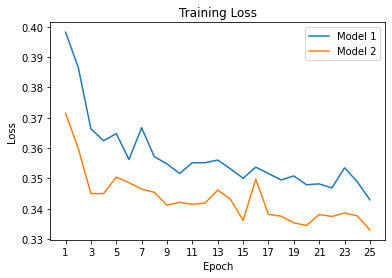

In [ ]:
plt.plot(range(1, epochs+1), train_loss_1, label = "Model 1")
plt.plot(range(1, epochs+1), train_loss_2, label = "Model 2")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(1, epochs+1, 2))
plt.legend()
plt.show()

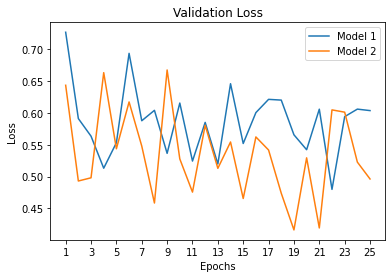

In [ ]:
plt.plot(range(1, epochs + 1), val_loss_1, label = "Model 1")
plt.plot(range(1, epochs + 1), val_loss_2, label = "Model 2")
plt.title("Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(range(1, epochs+1, 2))
plt.legend()
plt.show()

In [ ]:
with torch.no_grad():

    for i, (inputs, labels) in enumerate(test_loader): 
        outputs_1 = model_1(inputs)
        outputs_2 = model_2(inputs)

        # Get subset of the 
        norm_pos = (labels == 0).nonzero().flatten()
        pneu_pos = (labels == 1).nonzero().flatten()

        _, pred_1 = outputs_1.max(1)
        _, pred_2 = outputs_2.max(1)

        norm_1 = pred_1[norm_pos]
        norm_2 = pred_2[norm_pos]

        pneu_1 = pred_1[pneu_pos]
        pneu_2 = pred_2[pneu_pos]

        # Calculate the total accuracy of the model
        tot_samples = pred_1.size(0)

        tot_acc_1 = (pred_1 == labels).sum()
        tot_acc_2 = (pred_2 == labels).sum()

        # Calculate the class specific accuracies

        norm_samples = norm_pos.size(0)
        pneu_samples = pneu_pos.size(0)
        
        norm_acc_1 = (norm_1 == 0).sum()
        norm_acc_2 = (norm_2 == 0).sum()
        
        pneu_acc_1 = (pneu_1 == 1).sum()
        pneu_acc_2 = (pneu_2 == 1).sum()

        misclass_1 = (pred_1 != labels).nonzero().flatten()
        misclass_2 = (pred_2 != labels).nonzero().flatten()

        misclass_labels_1 = labels[misclass_1]
        misclass_labels_2 = labels[misclass_2]

        misclass_img_1 = inputs[misclass_1]
        misclass_img_2 = inputs[misclass_2]

        print("Model 1")
        print("=========")
        print(f"Normal Accuracy: {norm_acc_1} / {norm_samples} or {float(norm_acc_1) / float(norm_samples)}")
        print(f"Pneumonia Accuracy: {pneu_acc_1} / {pneu_samples} or {float(pneu_acc_1) / float(pneu_samples)}\n")
        print(f"Total Accuracy: {tot_acc_1} / {tot_samples} or {float(tot_acc_1) / float(tot_samples)}\n")
        
        print("Model 2")
        print("=========")
        print(f"Normal Accuracy: {norm_acc_2} / {norm_samples} or {float(norm_acc_2) / float(norm_samples)}")
        print(f"Pneumonia Accuracy: {pneu_acc_2} / {pneu_samples} or {float(pneu_acc_2) / float(pneu_samples)}\n")
        print(f"Total Accuracy: {tot_acc_2} / {tot_samples} or {float(tot_acc_2) / float(tot_samples)}")

Model 1
Normal Accuracy: 145 / 234 or 0.6196581196581197
Pneumonia Accuracy: 384 / 390 or 0.9846153846153847

Total Accuracy: 529 / 624 or 0.8477564102564102

Model 2
Normal Accuracy: 151 / 234 or 0.6452991452991453
Pneumonia Accuracy: 384 / 390 or 0.9846153846153847

Total Accuracy: 535 / 624 or 0.8573717948717948


In [ ]:
imgs_1 = []
imgs_2 = []

img_convert = transforms.ToPILImage()

tot_imgs = 8

for i in range(tot_imgs):
    imgs_1.append(img_convert(misclass_img_1[i+5]))
    imgs_2.append(img_convert(misclass_img_2[i+5]))

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       device='cuda:0')


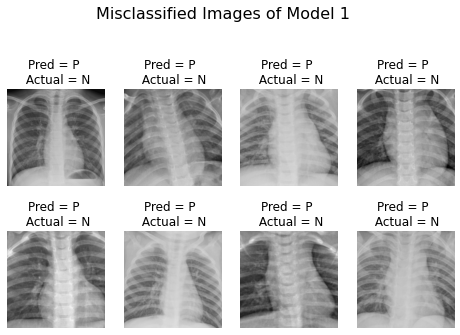

In [ ]:
rows = int(tot_imgs / 2)
columns = int(tot_imgs / 2)

classes = ["N", "P"]

print(misclass_labels_1)

fig = plt.figure(figsize=(8, 10))

fig.suptitle('Misclassified Images of Model 1', fontsize=16)

for i in range(0, tot_imgs):
    fig.add_subplot(rows, columns, i + 1)

    plt.imshow(imgs_1[i])
    plt.axis('off')
    pred_label = classes[0] if misclass_labels_1[i] == 1 else classes[1]
    plt.title(f"Pred = {pred_label} \n Actual = {classes[misclass_labels_1[i]]}")

plt.show()

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


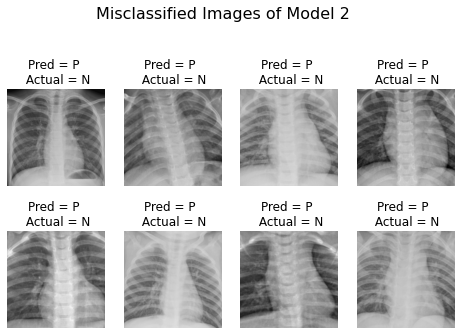

In [ ]:
fig = plt.figure(figsize=(8, 10))

fig.suptitle('Misclassified Images of Model 2', fontsize=16)

print(misclass_labels_2)

for i in range(0, tot_imgs):
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(imgs_1[i])
    plt.axis('off')
    pred_label = classes[0] if misclass_labels_2[i] == 1 else classes[1]
    plt.title(f"Pred = {pred_label} \n Actual = {classes[misclass_labels_2[i]]}")

plt.show()